# TP4: Morphological image processing

Morphological image processing is a collection of operations based on the shape of images. 
Classical morphological operators are designed for binary images processing but the operators can be extended to be applied on greyscale or colored images. In this session, we will only work with binary images, images only made of 0s and 1s.

The following notebook should be sufficient but you can find additional details in the following pages:
- https://en.wikipedia.org/wiki/Mathematical_morphology
- https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html


In [1]:
# The following packages will be useful throughout the session
!pip install -Uq pip numpy imageio scikit-image ipywidgets
!pip install -Uq matplotlib

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from ipywidgets import widgets, interact
import imageio

from TP4_utils import display_pixels, assert_binary_uint8, resize_and_fix_origin

/home/romaingrx/Documents/EPL/Q7/Cours/LELEC2885-Image processing and computer vision/LELEC2885-Practical-Sessions/TP4_utils.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  mpl.cm.get_cmap().set_bad(color='red')


## Morphological operators

The morphological operators take two inputs:
- an image (of shape $(W, H)$)
- and a structuring element known as _kernel_ (of shape $(w, h)$ with $w \ll W$ and $h \ll H$)

And output a transformed image (of shape $(W, H)$). They work (at least conceptually) by translating the kernel throughout the input image like a in a 2D convolution.

While the origin of the image is, by convention, in the top-left corner of the image, the origin of the kernel is often in the center, leading to negative coordinates elements. For the borders where the kernel can exit the bounds of the image, only the pixels within the image are considered.

## Basic operators

They are 2 basic operators
- **DILATION** tests whether the kernel "hits" or "intersect" with the neighbourhood of a pixel
- **EROSION** tests whether the kernel "fits" within the neighbourhood.

### Example
The library `scipy` comes with the two basic operators. You can play around below to see the effect of each operator with different kernel.

In [2]:
kernels = {
    "ball": "np.array([[0,1,0],[1,1,1],[0,1,0]])",
    "vertical_bar": "np.array([[0,1,0],[0,1,0],[0,1,0]])",
    "horizontal_bar": "np.array([[0,0,0],[1,1,1],[0,0,0]])",
    "dart": "np.array([[0,1,0],[0,1,1],[0,0,0]])"
}
operators = {
    "erosion": ndimage.binary_erosion,
    "dilation": ndimage.binary_dilation
}
@interact(operator=operators, kernel=kernels)
def _(operator, kernel):
    # Display kernel
    kernel = eval(kernel)
    display_pixels(plt.figure(figsize=(1,1)).gca(), kernel, "kernel used")
    
    # Loads a 8bits image and thresholds at 128
    # elements above 128 return True (or 1) and elements below 128 return False (or 0)
    image = imageio.imread("images/circuit.png") > 128

    # Create a 2 subplots figure
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    display_pixels(axes[0], image, title="original image")
    display_pixels(axes[1], operator(image, structure=kernel), title="modified image");

interactive(children=(Dropdown(description='operator', options={'erosion': <function binary_erosion at 0x7f066…

## Implementation

From a mathematical point of view, the **DILATION** operator is nothing else but a [Minkowski sum](https://en.wikipedia.org/wiki/Minkowski_addition) of the ensemble $E \in \mathbb{Z}^2$ and the kernel $K \in \mathbb{Z}^2$.

$$E \oplus K := \left\{ e+k | e \in E, k \in K \right\}$$

The most straightforward algorithm for computing the Minkowski sum $E \oplus K$ is to compute the sum $e+k$ for each pair $(e,k)$, where $e \in E$ and $k \in K$. However, this implementation requires to perform $|E|\times|K|$ operations, which is far from efficient!

Instead, there's a clever way by using the convolution operator that has a fast implementation in the Fourier domain (see first pratical session). For binary images:

$$E \oplus K = \mathcal{h}_\tau(E \ast K)$$

with $\mathcal{h}_\tau(x) = \begin{cases} 0, & \mbox{if } x < \tau \\ 1, & \mbox{otherwise } \end{cases} \hspace{1cm}$  with $0 < \tau < 1$ (generally, $\tau=0.5$).

The **EROSION** operator can be defined using the **DILATION** operator and working on $E^c:=\left\{e|e\notin E\right\}$, the complementary ensemble of $E$ and $\check{K}:=\left\{-k|k\in K\right\}$, the opposite of $K$:

$$E \ominus K = \left(E^c\oplus \check{K}\right)^c$$

### Exercice:
Implement effitiently (with `np.fft`) the `dilate` and `erode` functions using only numpy operations. You can assume the image is binary {0,1}.

**Hint:** You can use your implementation from the first practical session.

In [101]:
import numpy as np

def resize_and_fix_origin(kernel, size):
    """Pads a kernel to reach shape `size`, and shift it in order to cancel phase.
    This is based on the assumption that the kernel is centered in image space.
    """
    # Very specific routine... You don't have to understand it
    pad0, pad1 = size[0]-kernel.shape[0], size[1]-kernel.shape[1]
    # shift less if kernel is even, to start with 2 central items
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2

    kernel = np.pad(kernel, ((0,pad0), (0,pad1)))
    kernel = np.roll(kernel, (-shift0, -shift1), axis=(0,1))
    return kernel

def opposite(X):
    Xcopy = X.copy()
    for i in range(X.ndim):
        Xcopy = np.flip(Xcopy, i)
    return Xcopy

def dilate(image, kernel, tau):
    assert_binary_uint8(image) # sanity check image is binary

    # write your implementation here. Only numpy is allowed
    image_fft = np.fft.fft2(image)
    kernel_fft = np.fft.fft2(resize_and_fix_origin(kernel, image.shape))
    dilation_fft = image_fft * kernel_fft
    dilation_ifft = np.fft.ifft2(dilation_fft)
    
    dilation = 1 - (dilation_ifft < tau).astype(np.uint8)

    assert_binary_uint8(dilation) # sanity check dilation is binary
    return dilation

def erode(image, kernel, tau):
    assert_binary_uint8(image) # sanity check image is binary
    
    # write your implementation here. Only numpy is allowed
    erosion = dilate(1-image, opposite(kernel), tau)
    
    assert_binary_uint8(erosion) # sanity check erosion is binary
    return 1-erosion # Minskowski substraction

In [102]:
operators = {
    "erosion": erode,
    "dilation": dilate 
}

import ipywidgets as widgets

taus = widgets.FloatSlider(min=0, max=1, step=.01, value=.5)

@interact(operator=operators, kernel=kernels, tau=taus)
def _(operator, kernel, tau):
    # Display kernel
    kernel = eval(kernel).astype(np.uint8)
    display_pixels(plt.figure(figsize=(1,1)).gca(), kernel, "kernel used")
    
    # Loads a 8bits image and thresholds at 128
    # elements above 128 return True (or 1) and elements below 128 return False (or 0)
    image = 1-(imageio.imread("images/boat.png") > 128).astype(np.uint8)

    # Create a 2 subplots figure
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    display_pixels(axes[0], image, title="original image")
    display_pixels(axes[1], operator(image, kernel=kernel, tau=tau), title="your implementation")

    operator = ndimage.morphology.binary_erosion if operator == erode else ndimage.morphology.binary_dilation
    display_pixels(axes[2], operator(image, structure=kernel), title="scipy implementation")

interactive(children=(Dropdown(description='operator', options={'erosion': <function erode at 0x7f065ea3c290>,…

### Questions:
- What is the complexity of the naive implementation? n²k²
- What is the complexity of the implementation using the fast fourrier transform?
- Can you see differences with the `scipy` implementation used above (look on the borders when doing dilation)? Can you explain why we can observe that (hint in `TP1.5_student.ipynb` on moodle if you don't)?

## Opening and Closing
- **OPENING** is obtained by applying an erosion followed by a dilation. It can _open_ up a gap between objects connected by a thin bridge of pixels. Any regions that have survived the erosion are restored to their original size by the dilation.
- **CLOSING** is obtained by applying a dilation followed by an erosion. It can _fill holes_ while keeping object sizes.

The **OPENING** operator is the dual of the **CLOSING** operator, i.e. opening the foreground is equivalent to closing the background.

### Exercice:
Try implementing the **OPENING** and **CLOSING** operators using your functions `erode` and `dilate`

In [104]:
def opening(image, kernel):
    pipe = (erode, dilate)
    
    x = image.copy()
    for f in pipe:
        x = f(x, kernel, .5)
    
    return x

def closing(image, kernel):
    pipe = (dilate, erode)
    
    x = image.copy()
    for f in pipe:
        x = f(x, kernel, .5)
    
    return x 

### Exercice:
"pepper noise" (and "salt noise") are noises obtained by addition of black (or white) pixels to an image.
Try remove the salt and pepper noise from the following image using your functions.

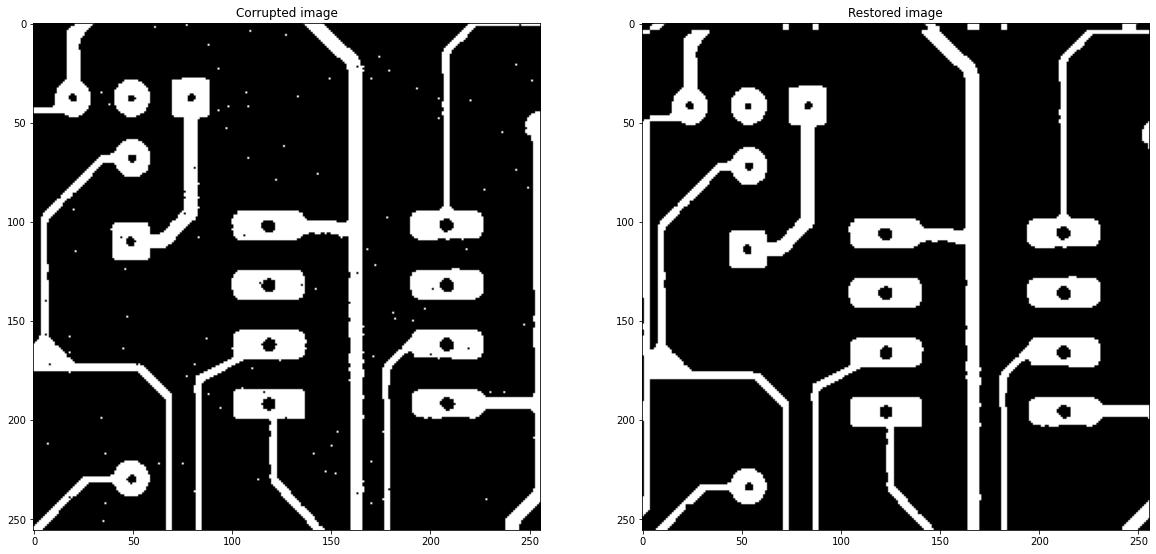

In [118]:
image = (imageio.imread("images/circuit_salt_and_pepper.png") > 128).astype(np.uint8)

def remove_salt_and_pepper_noise(image):
    pipe = (opening, closing)
    
    kernels = (
        #np.eye(2),
        #np.eye(2).T,
        
        np.array([[0,0],[1,1]]),
        np.array([[1,0],[1,0]]),
        
        #np.array([[0,0,0],[1,1,1],[0,0,0]]),
        #np.array([[0,1,0],[0,1,0],[0,1,0]]),
        
    )
    
    x = image.copy()
    for kernel in kernels:
        for f in pipe:
            x = f(x, kernel)
    return x

fig, axes = plt.subplots(1,2, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title("Corrupted image")
axes[1].imshow(remove_salt_and_pepper_noise(image))
axes[1].set_title("Restored image");

## Set theory operations
Set theory operations are usefull to build the next morphological operators

- **INTERSECTION** is the pixel-wise **AND** operator $I_A \cap I_B$
- **UNION** is the pixel-wise **OR** operator $I_A \cup I_B$
- **INVERT** is the pixel-wise **NOT** operator $\neg I$

### Exercice
Implement `intersection`, `union` and `invert`. Hint: `numpy` is fairly faster than any pure python implementation. Don't reinvent the wheel... and use (binary operators of) `numpy`. You can assume images are numpy arrays of type `np.uint8` with value 0 or 1, and that `input_image_1` and `input_image_2` have the same shape.

In [125]:
def intersection(input_image_1, input_image_2):
    assert_binary_uint8(input_image_1, input_image_2)
    # write your implementation here
    output_image = np.bitwise_and(input_image_1, input_image_2).astype(np.uint8)
    assert_binary_uint8(output_image)
    return output_image

def union(input_image_1, input_image_2):
    assert_binary_uint8(input_image_1, input_image_2)
    # write your implementation here
    output_image = np.bitwise_or(input_image_1, input_image_2).astype(np.uint8) 
    assert_binary_uint8(output_image)
    return output_image

def invert(input_image):
    assert_binary_uint8(input_image)
    # write your implementation here
    output_image = 1-input_image
    assert_binary_uint8(output_image)
    return output_image

Text(0.5, 1.0, 'invert(im2)')

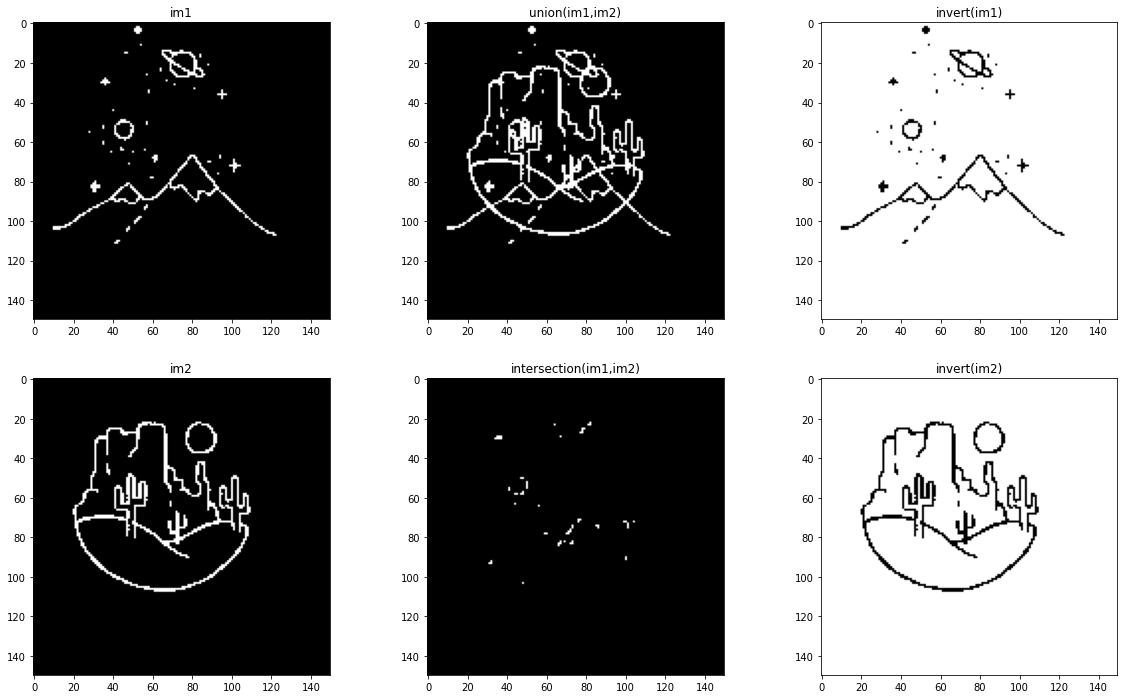

In [126]:
im1 = 1-(imageio.imread("images/draw1.png")[50:200,50:200] > 128).astype(np.uint8)
im2 = 1-(imageio.imread("images/draw2.png")[50:200,50:200] > 128).astype(np.uint8)

fig, axes = plt.subplots(2,3, figsize=(20,12))
axes[0][0].imshow(im1)
axes[0][0].set_title("im1")
axes[1][0].imshow(im2)
axes[1][0].set_title("im2")

axes[0][1].imshow(union(im1,im2))
axes[0][1].set_title("union(im1,im2)")
axes[1][1].imshow(intersection(im1,im2))
axes[1][1].set_title("intersection(im1,im2)")

axes[0][2].imshow(invert(im1))
axes[0][2].set_title("invert(im1)")
axes[1][2].imshow(invert(im2))
axes[1][2].set_title("invert(im2)")

## Hit and Miss 
The **HIT-AND-MISS** transform is a general binary morphological operation that can be used to look for particular patterns of foreground and background pixels in an image. As with other binary morphological operators it takes as input a binary image and a kernel, and produces another binary image as output.

The kernel is a slight extension to the kernel introduced above. It's values can be `1` for foreground, `0` for background and nothing for "don't care's". 

![kernel example](images/kerncrn1.gif "Kernel used to find right angle convex corner points in images.")

The **HIT-AND-MISS** operation is performed by translating the origin of the kernel to all points in the image and comparing it with the underlying image pixels. There's a _hit_ when the kernel exactly matches the foreground **and** background pixels of the image, resulting in a `1` in the output image, and a _miss_ else, resulting in a `0` in the output image. At the edges of the image, implementations can vary.

In our implementation, we'll use `np.nan` value for "don't care's" (which means "Not A Number") ; and we won't pay attention to the implementation at the edges.

### Exercice:
Implement the **HIT-AND-MISS** operator. If you think about it for a moment, you'll notice it's actually an intersection of two erosions...

In [275]:
def match(image, kernel):
    idx = (1 - np.isnan(kernel)).astype(np.bool)
    return 1 if (image[idx] == kernel[idx]).all() else 0

def hit_and_miss_row_worker(k, image, kernel, shift):
    out_vec = np.zeros(image.shape[1]-kernel.shape[1], dtype=image.dtype)
    for l in range(image.shape[1]-kernel.shape[1]):
            out_vec[l] = match(image[k:k+kernel.shape[0],l:l+kernel.shape[1]], kernel)
    return out_vec

def hit_and_miss_process(image, kernel):
    from multiprocessing import Pool
    from functools import partial
    
    assert_binary_uint8(image)
    output_image = np.zeros_like(image)
    
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2
    
    worker = partial(hit_and_miss_row_worker, image=image, kernel=kernel, shift=shift1)
    
    with Pool() as p:
        out = np.array(p.map(worker, np.arange(image.shape[0]-kernel.shape[0])))
        
    end0 = shift0+image.shape[0]-kernel.shape[0]
    end1 = shift1+image.shape[1]-kernel.shape[1]
    output_image[shift0:end0, shift1:end1] = out
    
    assert_binary_uint8(output_image)
    return output_image
    

def hit_and_miss(image, kernel): # zero padding for borders
    assert_binary_uint8(image)
    output_image = np.zeros_like(image)
    
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2
    
    for k in range(image.shape[0]-kernel.shape[0]):
        for l in range(image.shape[1]-kernel.shape[1]):
            output_image[k+shift0,l+shift1] = match(image[k:k+kernel.shape[0],l:l+kernel.shape[1]], kernel)
            
    assert_binary_uint8(output_image)
    return output_image

The **HIT-AND-MISS** operator allows to detect specific patterns in the image, like corners, or edges.

CPU times: user 282 ms, sys: 7.98 ms, total: 290 ms
Wall time: 286 ms


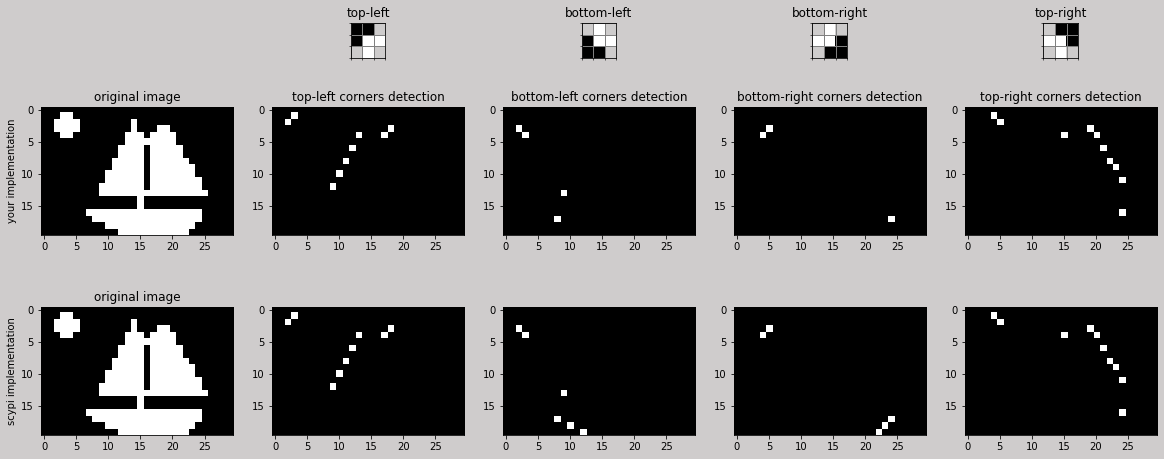

In [279]:
%%time
image = 1-(imageio.imread("images/boat.png") > 128).astype(np.uint8)

fig, axes = plt.subplots(3,5, figsize=(20,8), gridspec_kw={'height_ratios': [1,5,5]}, facecolor=bg_color)
axes[1,0].imshow(image)
axes[1,0].set_title("original image")
axes[2,0].imshow(image)
axes[2,0].set_title("original image")
axes[0,0].axis('off')
axes[1,0].set_ylabel("your implementation")
axes[2,0].set_ylabel("scypi implementation")

kernel = np.array([[   0  ,   0   ,np.nan],
                   [   0  ,   1   ,   1  ],
                   [np.nan,   1   ,np.nan]])

for i, name in enumerate(["top-left", "bottom-left", "bottom-right", "top-right"]):
    k = np.rot90(kernel, k=i)
    display_pixels(axes[0,i+1], k, name)
    axes[1,i+1].imshow(hit_and_miss(image, k))
    axes[1,i+1].set_title("{} corners detection".format(name))
    axes[2,i+1].imshow(ndimage.morphology.binary_hit_or_miss(image, k==1, k==0))

### Exercice:
Using the **HIT-AND-MISS** operator, implement `find_countours` that returns an image of the countours of an input binary image.

In [217]:
def find_countours(image):
    output_image = np.zeros_like(image)
    
    base_hkernel = np.zeros((2,2))
    base_hkernel[1] = 1
    
    base_eye = np.eye(2)
    base_eye[0,1]=np.nan
    
    
    kernels = ( # 8 directions
        base_hkernel,
        base_hkernel.T,
        base_hkernel[::-1],
        base_hkernel.T[:,::-1],
        base_eye,
        base_eye.T,
        base_eye[::-1],
        base_eye.T[::-1]
    )
    
    # Plot all kernels
    fig, axes = plt.subplots(ncols=8, figsize=(20,3))
    fig.suptitle("All kernels used")
    for kernel, ax in zip(kernels, axes):
        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
        
    for kernel in kernels:
        output_image = union(output_image, hit_and_miss(image, kernel))
    

    return output_image

Text(0.5, 1.0, 'countoured image')

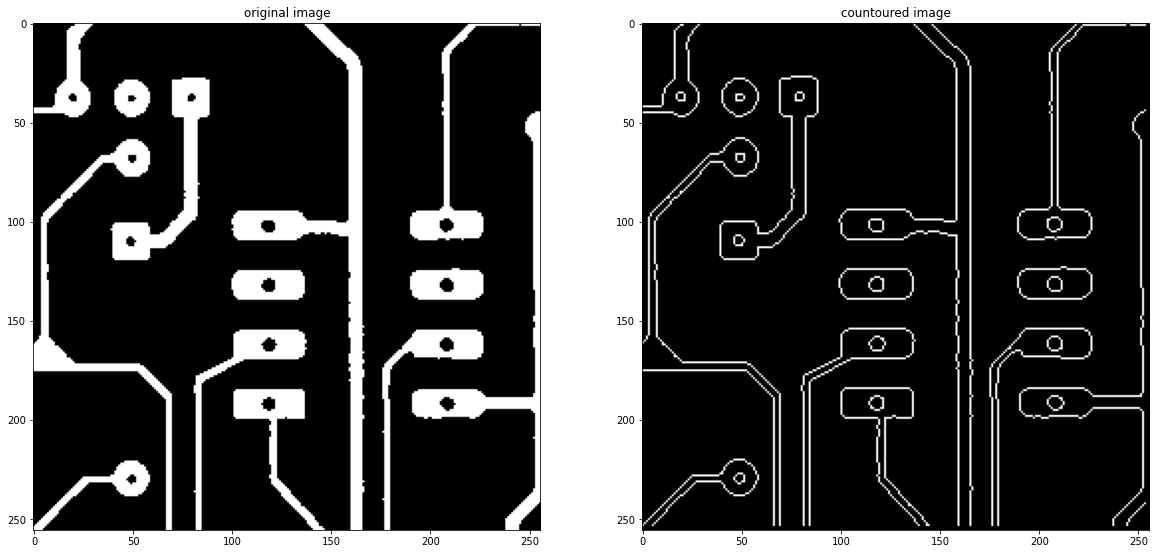

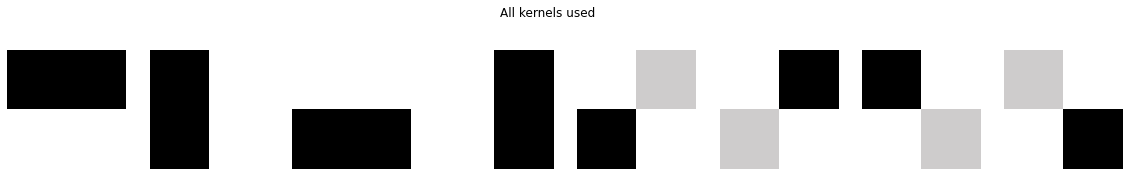

In [219]:
image = (imageio.imread("images/circuit_large.png")[:,:,0] > 128).astype(np.uint8)

fig, axes = plt.subplots(1,2, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title("original image")

axes[1].imshow(find_countours(image))
axes[1].set_title("countoured image")

Actually the **HIT-AND-MISS** operator is the most basic operation of binary morphology since almost all the other binary morphological operators can be derived from it.

## Thinning and Thickening

**THINNING** is used to remove selected foreground pixels from binary images.

In a thinning _pass_, when the kernel matches exactly the underlying pixels of the image, a `0` is written in the output image. Else, the output image takes the value of the input image. Note that a `0` at the origin of the kernel won't produce any effect.

The choice of structuring element determines under what situations a foreground pixel will be set to background, and hence it determines the application for the thinning operation. Usually, multiple structuring elements are applied to match several patterns.

**THICKENING** is used to grow selected regions of foreground pixels in binary images.

In a thickening _pass_, when the kernel matches exactly the underlying pixels of the image, a `1` is written in the output image. Else, the output image takes the value of the input image. Note that a `1` at the origin of the kernel won't produce any effect.

The **THICKENING** operator is the dual of the **THINNING** operator, i.e. thickening the foreground is equivalent to thinning the background.

Usually, the **THINNING** and **THICKENING** operators are applied on multiple kernels, repeatedly until convergence (there is no further changes to the image).


### Exercice
Implement `thicken` and `thin` using your previous functions. As those operators are usually applied with multiple kernels, we provide a list of kernels in argument of the functions.

In [307]:
from multiprocessing import Pool
from functools import partial

def hit_and_miss_worker(kernel, image):
    return hit_and_miss(image, kernel)

def thin(image, kernel_list, max_iter=1000):
    assert_binary_uint8(image)
    if not isinstance(kernel_list, list):
        kernel_list = [kernel_list]
        
    output_image = image.copy()
    for _ in range(max_iter):
        cache_image = output_image.copy()
       # for k in kernel_list:
       #     output_image = ouput_image - hit_and_miss(output_image, k)
        with Pool(len(kernel_list)) as pool:
            worker = partial(hit_and_miss_worker, image=output_image)
            hit_and_miss_kernels = pool.map(worker, kernel_list)
        for hm in hit_and_miss_kernels:
            output_image = intersection(output_image, 1-hm) 
        if np.array_equal(cache_image, output_image):
            break
        
    assert_binary_uint8(output_image)
    return output_image

def thicken(image, kernel_list, max_iter=1000):
    assert_binary_uint8(image)
    if not isinstance(kernel_list, list):
        kernel_list = [kernel_list]
        
    output_image = image.copy()
    for _ in range(max_iter):
        cache_image = output_image.copy()
        with Pool(len(kernel_list)) as pool:
            worker = partial(hit_and_miss_worker, image=output_image)
            hit_and_miss_kernels = pool.map(worker, kernel_list)
        for hm in hit_and_miss_kernels:
            output_image = union(output_image, hm)
        if np.array_equal(cache_image, output_image):
            break

    assert_binary_uint8(output_image)
    return output_image

## Convexe-hull
The convex hull of a binary shape can be visualized quite easily by imagining stretching an elastic band around the shape. The elastic band will follow the convex contours of the shape, but will 'bridge' the concave contours. The resulting shape will have no concavities and contains the original shape. Where an image contains multiple disconnected shapes, the convex hull algorithm will determine the convex hull of each shape, but will not connect disconnected shapes, unless their convex hulls happen to overlap (e.g. two interlocked 'U'-shapes).

An approximate convex hull can be computed using the **THICKENING** operator with the structuring elements shown below. The convex hull computed using this method is actually a '45° convex hull' approximation, in which the boundaries of the convex hull have orientations that are multiples of 45°. Note that this computation can be _very_ slow.

![kernel used for convex hull][thkhull]

[thkhull]: images/thkhull.png "kernel used for convex hull"
During each iteration of the thickening, each structuring element should be used in turn, and then in each of their 90° rotations, giving 8 effective structuring elements in total. The convex-hull is complete once the **THICKENING** reaches convergence.

### Exercice:

Implement the `convex_hull` function using your `thicken` function.

In [292]:
def convex_hull(image):
    # write your implementation here
    k1 = np.array([[1,1,0],[1,0,np.nan],[1,np.nan,0]])
    k2 = np.array([[np.nan,1,1],[np.nan,0,1],[0,np.nan,1]])
    
    kernels = [np.rot90(k, n) for k in (k1, k2) for n in range(4)]
    
    fig, axes = plt.subplots(ncols=8, figsize=(20,3))
    fig.suptitle("All kernels used for convex hull")
    for k, ax in zip(kernels, axes):
        ax.imshow(k, cmap="gray")
        ax.axis('off')
    
    output_image = image.copy()
    for k in kernels:
        output_image = thicken(image, [k])
    
    return output_image

CPU times: user 613 ms, sys: 4.18 s, total: 4.8 s
Wall time: 1min 5s


Text(0.5, 1.0, 'convex-hull approximation')

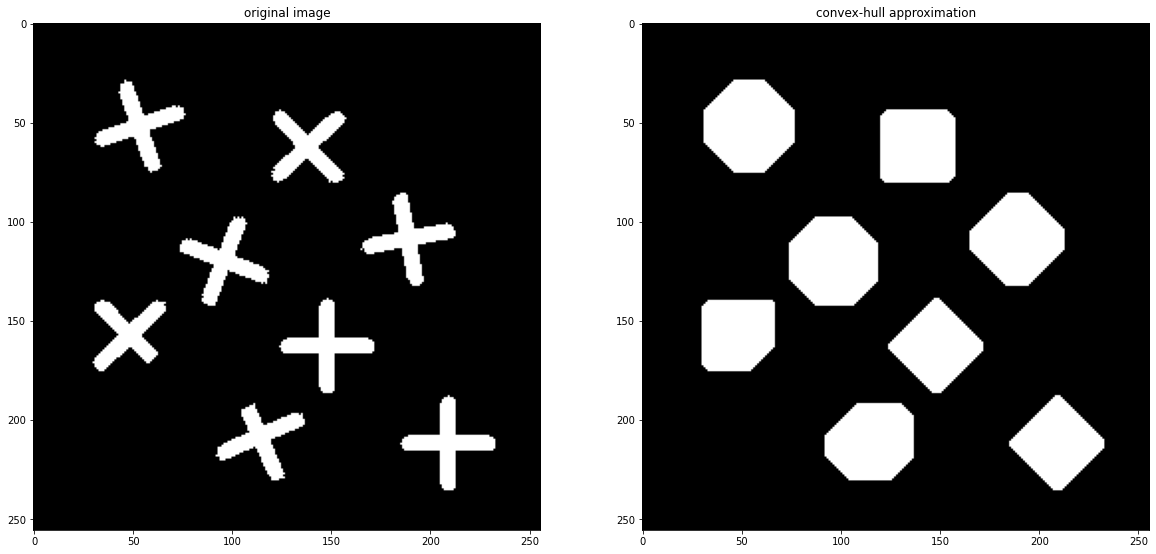

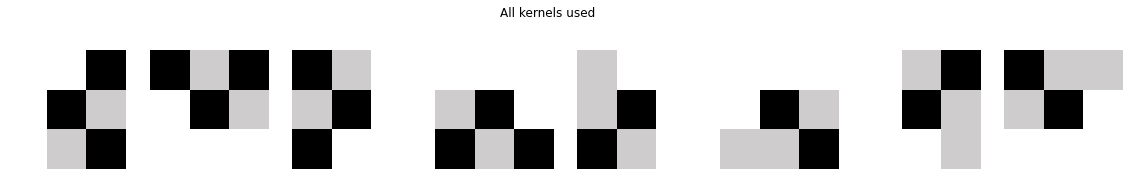

In [293]:
%%time
image = 1-(imageio.imread("images/crosses.png") < 128).astype(np.uint8)

fig, axes = plt.subplots(1,2, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title("original image")

axes[1].imshow(convex_hull(image))
axes[1].set_title("convex-hull approximation");

## Skeletonization

Skeletonization is a process for reducing foreground regions in a binary image to a skeletal remnant that largely preserves the extent and connectivity of the original region while throwing away most of the original foreground pixels. To see how this works, imagine that the foreground regions in the input binary image are made of some uniform slow-burning material. Light fires simultaneously at all points along the boundary of this region and watch the fire move into the interior. At points where the fire traveling from two different boundaries meets itself, the fire will extinguish itself and the points at which this happens form the so called _quench line_. This line is the skeleton. Under this definition it is clear that thinning produces a sort of skeleton.

An approximate skeleton can be computed using the **THINNING** operator with specific structuring elements.
This approximate actually gives the "octagonal skeleton" of the binary shape (the set of points that lie at the centers of octagons that fit entirely inside the shape, and which touch the boundary of the shape at at least two points).

Similar to the convex-hull, the skeleton is complete once the **THINNING** reaches convergence.

### Exercice
Implement the `skeletonize` function using your `thin` function. First, you have to select the adequate kernels.

**Hint:** they are 2 different kernels, each rotated in the 4 directions, making 8 effective kernels.

In [311]:
def skeletonize(image):
    assert_binary_uint8(image)
    # write your implementation here
    k1 = np.array([[0,0,0],[np.nan,1,np.nan],[1,1,1]])
    k2 = np.array([[np.nan,0,0],[1,1,0],[np.nan,1,np.nan]])
    
    kernels = [np.rot90(k, n) for k in (k1, k2) for n in range(4)]
    
    fig, axes = plt.subplots(ncols=8, figsize=(20,3))
    fig.suptitle("All kernels used")
    for k, ax in zip(kernels, axes):
        ax.imshow(k, cmap="gray")
        ax.axis('off')
    
    output_image = image.copy()
    for k in kernels:
        output_image = thin(output_image, [k])
    
    assert_binary_uint8(output_image)
    return output_image

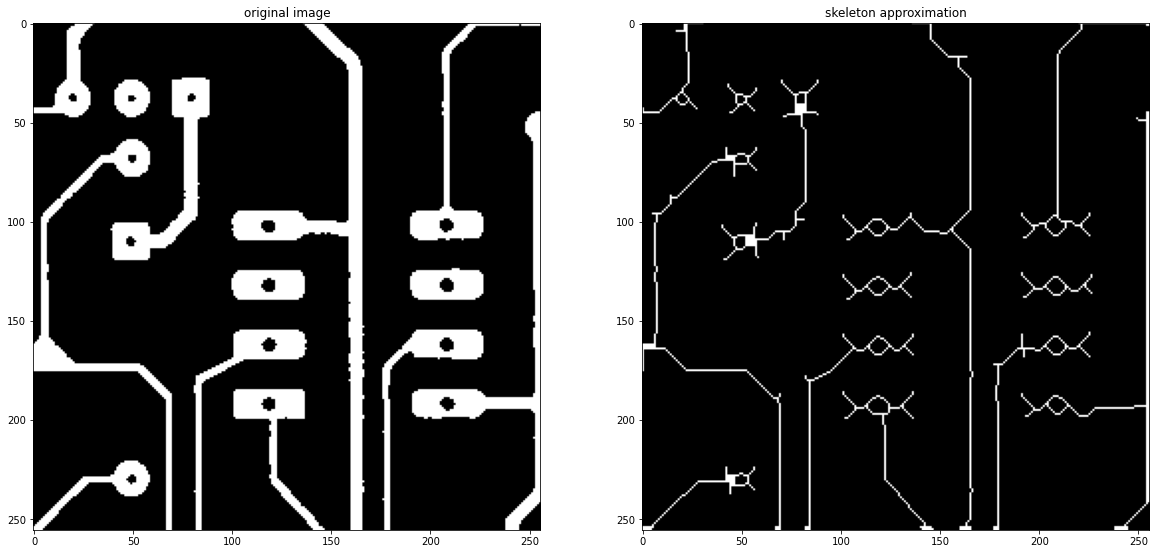

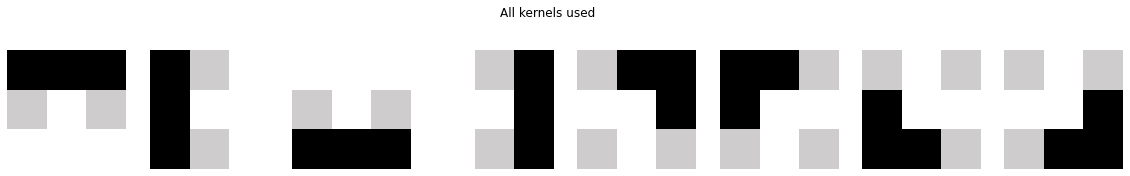

In [312]:
image = 1-(imageio.imread("images/circuit_large.png")[...,0] < 128).astype(np.uint8)

fig, axes = plt.subplots(1,2, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title("original image")

axes[1].imshow(skeletonize(image))
axes[1].set_title("skeleton approximation");

Note that skeletons produced by this method often contain undesirable short _spurs_ produced by small irregularities in the boundary of the original object. These _spurs_ can be removed by a process called pruning, which is in fact just another sort of thinning.

## Exercice
Implement the function `prune` that removes these spurs

In [309]:
def prune(image):
    assert_binary_uint8(image)
    
    kernels = (np.array([
            [np.nan,   0   ,   0   ],
            [np.nan,   1   ,   0   ],
            [   0  ,   0   ,   0   ]
        ]),
        np.array([
            [np.nan,   1   , np.nan],
            [   1  ,   1   ,   1   ],
            [np.nan,   1   , np.nan]
        ]),
        np.array([
            [   1  ,   1   ,   1  ],
            [   1  ,   1   ,   1  ],
            [   1  ,   1   ,   1  ]
        ]))
    
    kernels = [np.rot90(k, n) for k in kernels for n in range(4)]
    
    fig, axes = plt.subplots(ncols=8, figsize=(20,3))
    fig.suptitle("All kernels used")
    for k, ax in zip(kernels, axes):
        ax.imshow(k, cmap="gray")
        ax.axis('off')
    
    output_image = thin(image, kernels)
    
    
    assert_binary_uint8(output_image)
    return output_image

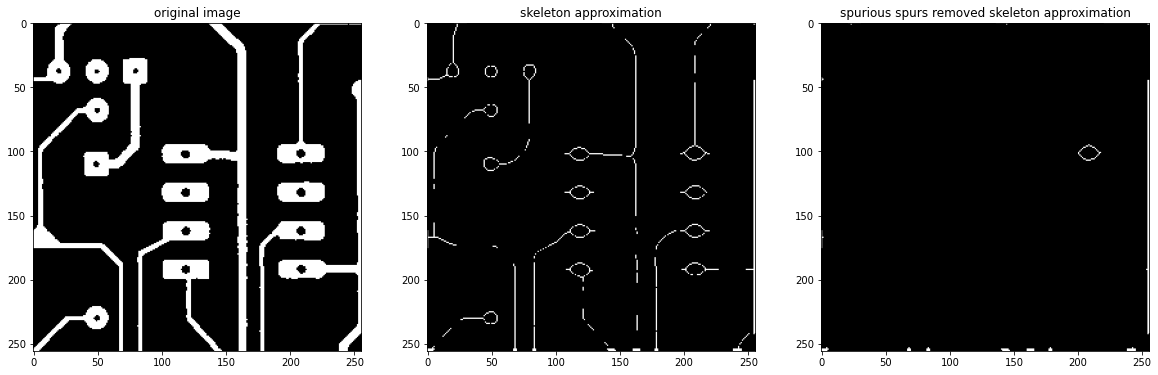

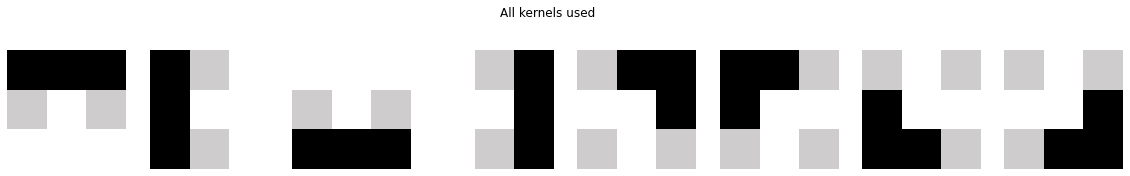

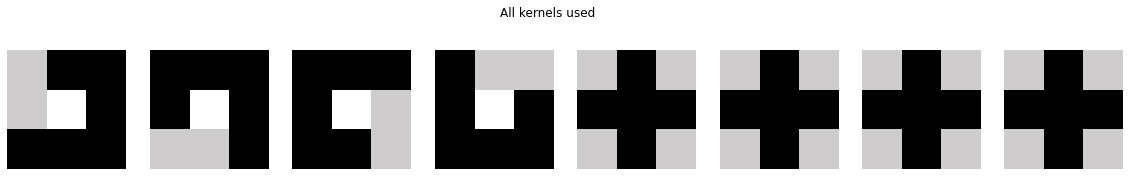

In [310]:
image = 1-(imageio.imread("images/circuit_large.png")[...,0] < 128).astype(np.uint8)

fig, axes = plt.subplots(1,3, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title("original image")

skeleton = skeletonize(image)
axes[1].imshow(skeleton)
axes[1].set_title("skeleton approximation")

axes[2].imshow(prune(skeleton))
axes[2].set_title("spurious spurs removed skeleton approximation");